## Introduction

Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository1): CRIM: per capita crime rate by town

1. CRIM - per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to ﬁve Boston employment centers
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per 10,000 doller
11. PTRATIO: pupil-teacher ratio by town 
12. B: (1000(Bk−0.63)2) where Bk is the proportion of blacks by  
13. LSTAT: % lower status of the population
14. MEDV: Median value of owner-occupied homes in 1000 doller

**In this we have to create a machine learning model to predict `MEDV` from the given data.**

## Importing Libraries

In [282]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from functools import partial

from sklearn.metrics.pairwise import rbf_kernel
from Aggregation_penalise_covariance import Agregator

## Load Model

In [283]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('../data_driven_aggregation/housing.csv', header=None, delimiter=r"\s+", names=columns)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


## Features and predicter variable

In [285]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X = df.loc[:,features]
y = df['MEDV']

In [286]:
#normalize features
X = (X - X.mean()) / X.std()

In [287]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train_reduced, X_val, y_train_reduced, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=2)

## Model Selection/Creation 

In [288]:
# Define the models
models = [LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(), 
          #SVR(), 
          KNeighborsRegressor(), 
          GradientBoostingRegressor()
         ]

# Define the model names
model_names = ['Linear Regression', 
               'Decision Tree', 
               'Random Forest', 
               #'Support Vector Regression', 
               'KNeighbors Regression', 
               'Gradient Boosting Regression'
              ]
model_number=len(models)

## Model Training and testing

In [289]:
# Define a dictionary to store the model performances
performances = {}

# Train the models and evaluate their performances
for model, name in zip(models, model_names):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the performance metrics in the dictionary
    performances[name] = [mae, mse, r2]

In [290]:
class EnsembleAggregation:
    def __init__(self, models,validation_x,validation_y):
        self.models=models
        self.x=validation_x
        self.y=validation_y

    
    def compute_alpha(self):
        M_vec=self.M(self.x)
        self._cov=np.mean(np.expand_dims(M_vec,0)*np.expand_dims(M_vec,1),axis=-1)
        self._cor_y=np.mean(M_vec*np.array(self.y)[np.newaxis,...],axis=-1)
        self._alpha=np.linalg.solve(self._cov,self._cor_y)

    
    @property
    def alpha(self):
        try:
            return self._alpha
        except:
            self.compute_alpha()
            return self._alpha


    @alpha.deleter
    def alpha(self):
        del self._alpha
    
    def M(self,x):
        return np.array(list(map(lambda model:model(x), self.models)))

    def __call__(self, x):
        return np.dot(self.alpha,self.M(x))

## Performance visualization

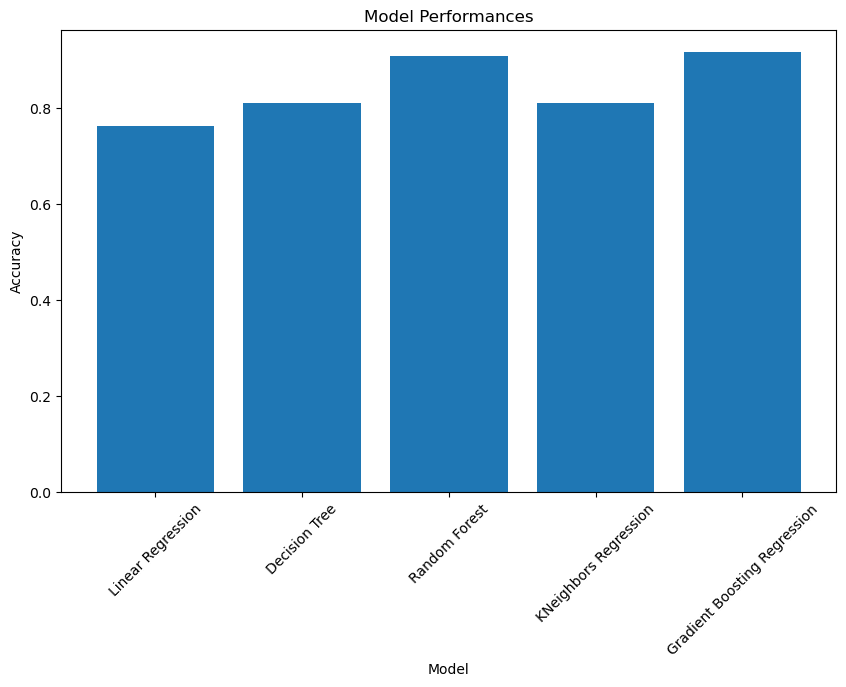

In [291]:
# Visualize the performances
plt.figure(figsize=(10, 6))
plt.bar(performances.keys(), [p[2] for p in performances.values()])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performances')
plt.xticks(rotation=45)
plt.show()

# Gaussian aggregation

In [292]:
models_reduced=[LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(), 
          #SVR(), 
          KNeighborsRegressor(), 
          GradientBoostingRegressor()
         ]
model_number=len(models_reduced)
models_reduced=[m.fit(X_train_reduced.to_numpy(),y_train_reduced.to_numpy()) for m in models_reduced]

In [293]:
ratio=0.5
model_values=np.stack(list(map(lambda x: x.predict(X_test.to_numpy()),models_reduced)),axis=0)
constant_mat=(1-ratio)*np.eye(model_number)+ratio*np.corrcoef(model_values-y_test.to_numpy()[None,:])
constant_mat

array([[1.        , 0.17983086, 0.28781911, 0.37331725, 0.29848638],
       [0.17983086, 1.        , 0.37817542, 0.20136853, 0.28794985],
       [0.28781911, 0.37817542, 1.        , 0.31332887, 0.41886666],
       [0.37331725, 0.20136853, 0.31332887, 1.        , 0.32835147],
       [0.29848638, 0.28794985, 0.41886666, 0.32835147, 1.        ]])

In [294]:
lengthscales=X_train.to_numpy()[:,None,:]-X_train.to_numpy()[None,:,:]
lengthscales=np.mean(np.abs(lengthscales),axis=(0,1))
lengthscales

array([0.69578531, 0.80859088, 1.11824057, 0.57429714, 1.12299431,
       1.05547035, 1.13452527, 1.09677066, 0.97114756, 1.07530193,
       1.10082885, 0.70997478, 1.11143548])

In [295]:
def linear_separable_kernel(x,y,mat):
    K=x@y.T+1
    return K[:,:,None,None]*mat[None,None,:,:]

def gaussian_separable_kernel(x,y,mat,l):
    distances=(x[:,None,:]-y[None,:,:])/l[None,None,:]
    K=np.exp(-np.sum(np.square(distances),axis=-1)/2)+1

    return K[:,:,None,None]*mat[None,None,:,:]

my_kernel=partial(gaussian_separable_kernel,mat=constant_mat,l=0.8*np.ones(X.shape[1]))

In [296]:
aggregate=Agregator(K=my_kernel,models=models_reduced,kernel_name='gaussian',intercept_choice='fit')

In [297]:
#aggregate=aggregate.fit(X_val.to_numpy(),y_val.to_numpy(),alpha=1e-4,cov_regularizer=10)
#aggregate=aggregate.fit(X_train.to_numpy(),y_train.to_numpy(),alpha=20,cov_regularizer=1)

In [298]:
'''res={'alpha':[],'cov_regularizer':[],'mae':[]}
for alpha in np.logspace(-4,2,15):
    for cov_regularizer in np.logspace(-4,2,15):
        aggregate=aggregate.fit(X_train.to_numpy(),y_train.to_numpy(),alpha=alpha,cov_regularizer=cov_regularizer)
        y_pred = aggregate.predict(X_test.to_numpy())
        res['alpha'].append(alpha)
        res['cov_regularizer'].append(cov_regularizer)
        res['mae'].append(mean_absolute_error(y_test, y_pred))
#find the best alpha and cov_regularizer
res=pd.DataFrame(res)
res.sort_values(by='mae').head()'''

"res={'alpha':[],'cov_regularizer':[],'mae':[]}\nfor alpha in np.logspace(-4,2,15):\n    for cov_regularizer in np.logspace(-4,2,15):\n        aggregate=aggregate.fit(X_train.to_numpy(),y_train.to_numpy(),alpha=alpha,cov_regularizer=cov_regularizer)\n        y_pred = aggregate.predict(X_test.to_numpy())\n        res['alpha'].append(alpha)\n        res['cov_regularizer'].append(cov_regularizer)\n        res['mae'].append(mean_absolute_error(y_test, y_pred))\n#find the best alpha and cov_regularizer\nres=pd.DataFrame(res)\nres.sort_values(by='mae').head()"

In [299]:
aggregate=aggregate.fit(X_val.to_numpy(),y_val.to_numpy(),alpha=1e-3,cov_regularizer=5)

In [300]:
y_pred = aggregate.predict(X_test.to_numpy())

# Calculate the performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Store the performance metrics in the dictionary
performances['aggregation'] = [mae, mse, r2]

In [301]:
performances

{'Linear Regression': [3.7507121808389177,
  23.38083648027023,
  0.7634174432138472],
 'Decision Tree': [3.069607843137255, 18.536176470588234, 0.8124388737694809],
 'Random Forest': [2.3280588235294113, 8.998269901960787, 0.9089496348065147],
 'KNeighbors Regression': [2.908627450980392,
  18.630235294117647,
  0.8114871252305582],
 'Gradient Boosting Regression': [2.2026300893463095,
  8.156785253944136,
  0.9174643254460934],
 'aggregation': [2.4413044785226474, 10.904092011186819, 0.88966528337791]}

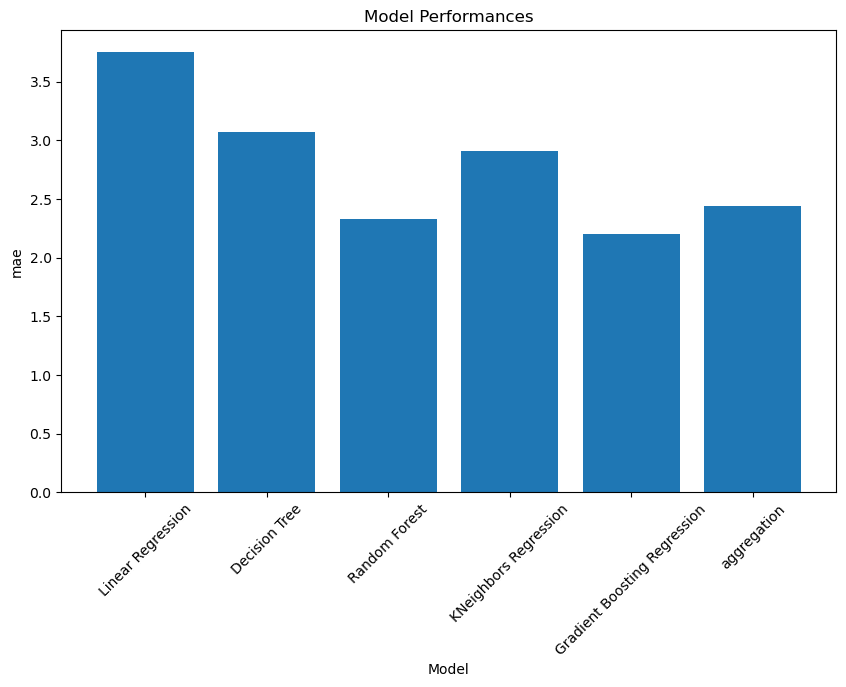

In [302]:
# Visualize the performances
plt.figure(figsize=(10, 6))
plt.bar(performances.keys(), [p[0] for p in performances.values()])
plt.xlabel('Model')
plt.ylabel('mae')
plt.title('Model Performances')
plt.xticks(rotation=45)
plt.show()

# Let's see what's the best we can do? 

In [311]:
train_or_test='val'
assert train_or_test in ['train','test','val']
if train_or_test=='train':
    X_train_or_test=X_train_reduced.to_numpy()
    y_train_or_test=y_train_reduced.to_numpy()
elif train_or_test=='test':
    X_train_or_test=X_test.to_numpy()
    y_train_or_test=y_test.to_numpy()
else:
    X_train_or_test=X_val.to_numpy()
    y_train_or_test=y_val.to_numpy()


In [312]:
diffs=[]
for model, name in zip(models_reduced, model_names):
    
    # Make predictions on the test set
    y_pred = model.predict(X_train_or_test)
    diff=np.abs((y_pred-y_train_or_test))
    diffs.append(diff)
y_pred,alpha = aggregate.predict(X_train_or_test,return_alpha=True)
diff=np.abs((y_pred-y_train_or_test))
diffs.append(diff)
diffs=np.stack(diffs,axis=0)

In [313]:
diffs.shape

(6, 61)

In [314]:
model_names+['aggregation']

['Linear Regression',
 'Decision Tree',
 'Random Forest',
 'KNeighbors Regression',
 'Gradient Boosting Regression',
 'aggregation']

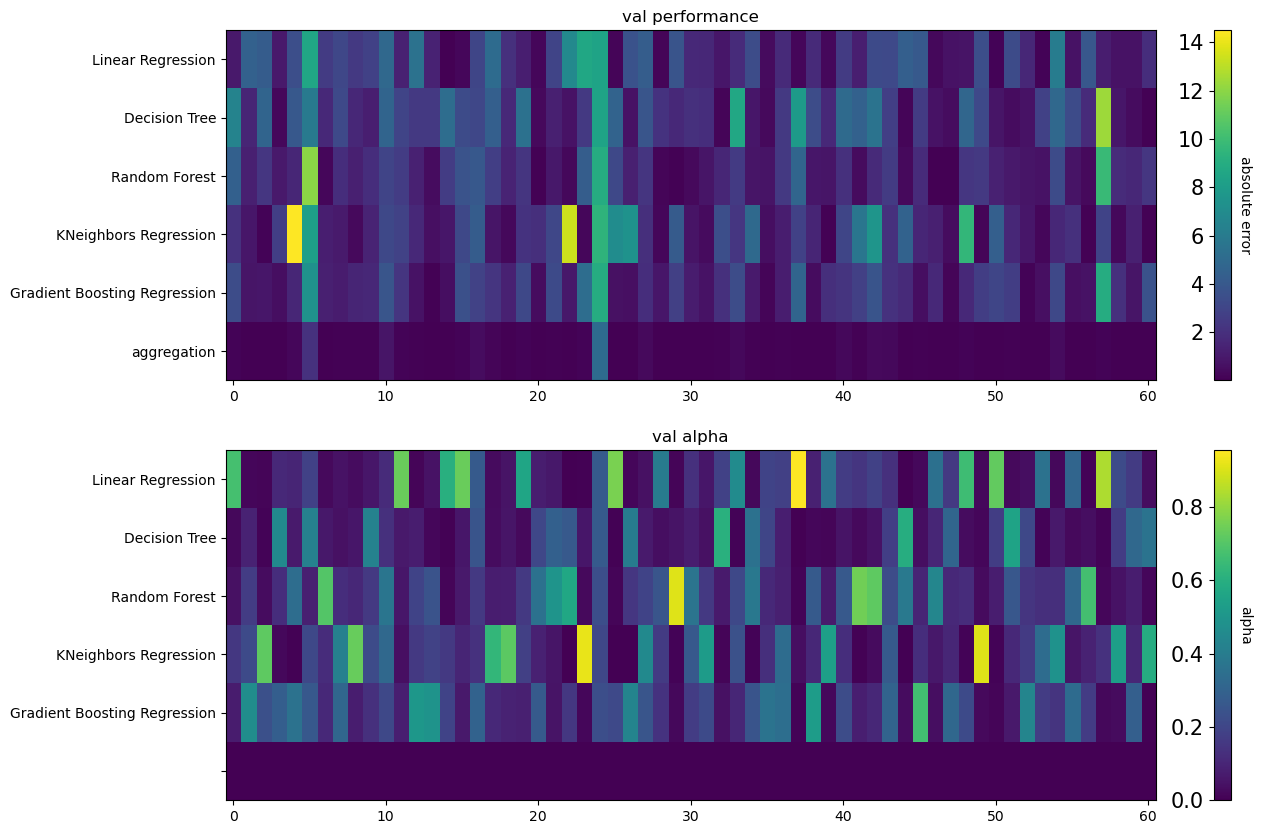

In [315]:

#change xticks labels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.imshow(np.abs(diffs), aspect='auto')
ax1.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+['aggregation'])
#show colorbar
cbar = fig.colorbar(ax1.imshow(np.abs(diffs), aspect='auto'))
cbar.ax.set_ylabel('absolute error', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')

# change xticks labels

# make title for subplots saying if it is train or test, as well as left is performance, right is alpha
ax1.set_title(f'{train_or_test} performance')
ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto')
ax2.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+[''])
#show colorbar
cbar = fig.colorbar(ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto'))
cbar.ax.set_ylabel('alpha', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')


ax2.set_title(f'{train_or_test} alpha')
plt.show()

In [316]:
np.argmin(np.abs(diffs),axis=0)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

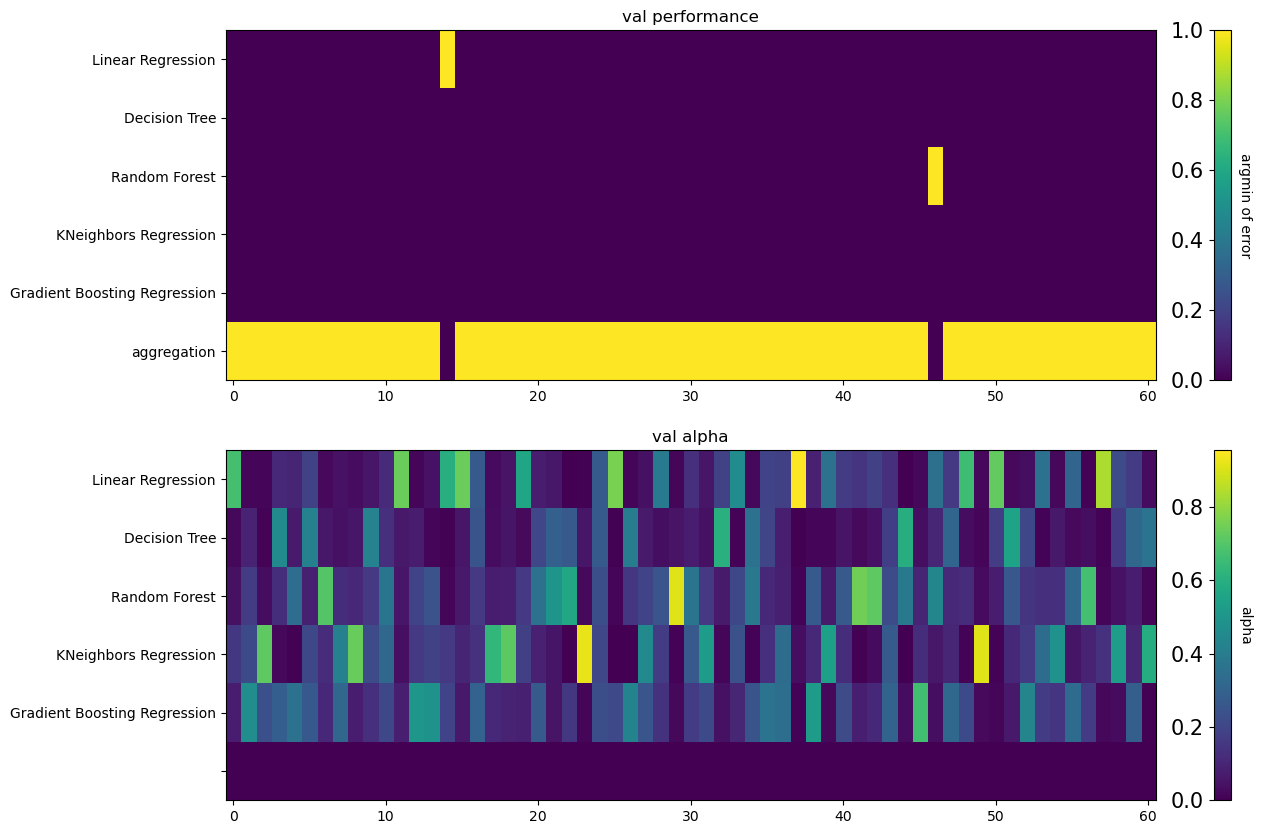

In [317]:

one_hot=np.zeros((diffs.shape[0],diffs.shape[1]))
one_hot[np.argmin(np.abs(diffs),axis=0),np.arange(diffs.shape[1])]=1
#same plot as above but with one hot encoding instead of performance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.imshow(one_hot, aspect='auto')
ax1.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+['aggregation'])
#show colorbar
cbar = fig.colorbar(ax1.imshow(one_hot, aspect='auto'))
cbar.ax.set_ylabel('argmin of error', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')

# change xticks labels

# make title for subplots saying if it is train or test, as well as left is performance, right is alpha
ax1.set_title(f'{train_or_test} performance')
ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto')
ax2.set_yticks(ticks=np.arange(len(model_names)+1),labels=model_names+[''])
#show colorbar
cbar = fig.colorbar(ax2.imshow(np.concatenate([alpha,np.zeros((1,alpha.shape[1]))]), aspect='auto'))
cbar.ax.set_ylabel('alpha', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('right')


ax2.set_title(f'{train_or_test} alpha')
plt.show()


In [318]:
best_model_performance=np.min(np.mean(diffs,axis=1))
print(best_model_performance)
best_possible_performance=np.mean(np.min(diffs,axis=0))
print(best_possible_performance)

0.22648124032689196
0.22612129061180786
